In [1]:
#imports

import torch.cuda as cuda
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
import torchvision.models as models
import random
import torchvision.transforms as transforms
import os
import math
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score, hamming_loss

In [2]:
#this cell will load the data and put it into tensors for training

max_samples = 50000 #how many samples to use, -1 is all of them

#VGG_16 dataloader: its the same thing but the transforms are slightly off
#only works on dominiks computer
#adding a section to split data intro training/testing/validation
#just keeping it to 50k to make things easier

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

totensor = transforms.ToTensor()

celeb_data = {}
k = os.listdir("celeba/img_align_celeba")

imageno = 0
with open("celeba/list_attr_celeba.csv") as labels:
    classes = labels.readline()
    classes = classes.split(sep = ",")

    for l in k:

        if(max_samples != -1 and imageno > max_samples):
            break

        lab = labels.readline().split(sep=",")
        lab[-1] = lab[-1].replace('\n', "")

        name = lab[0]
        lab.pop(0)
        #print(lab_copy)
        celeb_data[name] = (transform1(plt.imread("celeba/img_align_celeba/" + l)),(torch.FloatTensor([int(k) for k in lab])))
        imageno +=1
        
        #progress bar :)
        if(imageno%(max_samples/100) == 0):
            percent = round(imageno/max_samples*100, 3)
            percent = ('%.0f' %percent)
            print('\r' + str(percent) + "% Complete", end='', flush=True)
        

C:\Users\Dominik Danda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


100% Complete

In [3]:
#this cell will shuffle and split the dataset

sample_ratio = (8, 1, 1) #the ratio used to split the data, does not need to add up to 10
shuf_list = list(celeb_data.keys())
random.shuffle(shuf_list) #I really hope that shuffling a list this long doesnt take that much time

imageno = 0
train_data = []
val_data = []
test_data = []

train_sample_num = sample_ratio[0]/math.fsum(sample_ratio)*max_samples
val_sample_num = sample_ratio[1]/math.fsum(sample_ratio)*max_samples
test_sample_num = sample_ratio[2]/math.fsum(sample_ratio)*max_samples

for i in shuf_list:
    if imageno < (train_sample_num):
        train_data.append(i)
    elif imageno >= (train_sample_num) and imageno < (train_sample_num+val_sample_num):
        val_data.append(i)
    else:
        test_data.append(i)
    imageno += 1

print(len(train_data))
print((train_data[0]))

40000
001741.jpg


In [4]:
#this cell initializes the network

vgg = models.vgg16(pretrained=True)
vgg.features = vgg.features.cuda()

#the output of vgg.features is 512*7*7, we need to build our own classifier

C:\Users\Dominik Danda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Dominik Danda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
#this cell formats the data for the classifier

train_data_2 = []

counter = 0
for i in train_data:
    with torch.no_grad():
        j = vgg.features(celeb_data[i][0].cuda())
    train_data_2.append((j,celeb_data[i][1]))
    cuda.empty_cache()
     
    if(counter%(len(train_data)/100) == 0):
            percent = round(counter/len(train_data)*100, 3)
            percent = ('%.0f' %percent)
            print('\rTrain Data is ' + str(percent) + "% Complete", end='', flush=True) 
    counter += 1

val_data_2 = []

counter = 0
for i in val_data:
    with torch.no_grad():
        j = vgg.features(celeb_data[i][0].cuda())
    val_data_2.append((j,celeb_data[i][1]))
    cuda.empty_cache()
    
    if(counter%(len(val_data)/100) == 0):
            percent = round(counter/len(val_data)*100, 3)
            percent = ('%.0f' %percent)
            print('\rValidation Data is ' + str(percent) + "% Complete           ", end='', flush=True) 
    counter += 1

test_data_2 = []

counter = 0
for i in test_data:
    with torch.no_grad():
        j = vgg.features(celeb_data[i][0].cuda())
    test_data_2.append((j,celeb_data[i][1]))
    cuda.empty_cache()
     
    if(counter%(len(test_data)/100) == 0):
            percent = round(counter/len(test_data)*100, 3)
            percent = ('%.0f' %percent)
            print('\rTest Data is ' + str(percent) + "% Complete                 ", end='', flush=True) 
    counter += 1

Test Data is 0% Complete                  

In [6]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    name = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return name


In [7]:
#classifier, along with evaluate/train functions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class vgg_classifier(nn.Module):
    def __init__(self):
        super(vgg_classifier, self).__init__()
        self.fc1 = nn.Linear(512*7*7, 16, bias = True)
        self.fc2 = nn.Linear(16, 16, bias = True)
        #don't want to explode the feature map too much

    def forward(self, x):
        x = x.view(-1, 512*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#evaluate function (put the evaluation data into 1 big batch and compute error/loss)
def vgg_evaluate(model, data_list):
    criterion = nn.BCEWithLogitsLoss()
    total_acc = 0
    total_loss = 0
    for i in range(len(data_list)):
        inputs = data_list[i][0]
        labels = data_list[i][1]
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        labels = torch.stack([labels])
        outputs = model(inputs)
        #print(outputs.shape)
        #print(outputs)
        #outputs = torch.flatten(outputs)
        #print(labels.shape)

        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        preds = (probs > 0.5).astype(int)
        targets_np = labels.cpu().numpy()
        accuracy = hamming_loss(targets_np, preds)
        total_acc += accuracy
        #print(accuracy,total_acc)
        

    return (total_acc/len(data_list), total_loss/len(data_list))

#training loop
def vgg_train(model, train_list, val_list, epochs, learning_rate, batch_size):
    #train/val_list: train_data,val_data
    #train_data = list of tuples (i,j), i = 
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    criterion = nn.BCEWithLogitsLoss()
    train_acc = np.zeros(epochs)
    train_loss = np.zeros(epochs)
    val_acc = np.zeros(epochs)
    val_loss = np.zeros(epochs)
    #state_dict_list = [] #gonna leave this unfinished for now
    epoch = 0
    
    for i in range(epochs):
        total_acc = 0
        total_train_loss = 0
        counter = 0
        train_list_copy = train_list[:]
        random.shuffle(train_list_copy)
        
        while train_list_copy:
            batch = train_list_copy[:batch_size]
            train_list_copy = train_list_copy[batch_size:]
            inputs = torch.stack([i[0] for i in batch])
            labels = torch.stack([i[1] for i in batch])
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            
        
            outputs = model(inputs)
            
            #print(outputs.shape)
            #print(labels.shape)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            #print(probs)
            preds = (probs > 0.5).astype(int)
            #print(preds)
            targets_np = labels.cpu().numpy()
            #print(targets_np)
            accuracy = hamming_loss(targets_np, preds)
            total_acc += accuracy 
            #print(accuracy,total_acc)
            #break
            if(counter%(len(train_list)/batch_size/100) == 0):
                percent = round(counter/(len(train_list)/batch_size)*100, 3)
                percent = ('%.0f' %percent)
                print('\rThis epoch is ' + str(percent) + "% Complete", end='', flush=True) 
            counter += 1
        print("\n")
            
        
      
        train_acc[epoch] = float(total_acc) / (len(train_list)/batch_size)
        train_loss[epoch] = float(total_train_loss) / (len(train_list)/batch_size) 
        (val_acc[epoch], val_loss[epoch]) = vgg_evaluate(model, val_list)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        
        #checkpoint the model, if val err is lower than the lowest val err so far
        if epoch > 0 and val_acc[epoch] < np.min(val_acc[:epoch]):
            best_epoch = epoch
            name = get_model_name("baseline_net", batch_size, learning_rate, best_epoch)
            best_model_wts = model.state_dict()
            
            #print("New best model found and saved")
            #os.de
        
        epoch += 1
        # Save the current model (checkpoint) to a file, checkpoint every epoch
        #not saving it to a file, I'm getting some runtime errors I don't wanna deal with, I'm just saving the state_dict


    #state_dict_list.append((model.state_dict(),epoch))
    torch.save(best_model_wts, "checkpoints/"+ name)
    print('Finished Training')

    # plot the train/val loss/errors

    num_epochs = np.arange(1, epochs + 1)

    plt.title("Train vs Validation Error")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

This epoch is 96% Complete

Epoch 1: Train acc: 0.274090625, Train loss: 0.5613028924942016 |Validation acc: 0.168125, Validation loss: 0.4532789856821299
This epoch is 96% Complete

Epoch 2: Train acc: 0.1666625, Train loss: 0.41679997272491454 |Validation acc: 0.1621125, Validation loss: 0.38832315423190594
This epoch is 96% Complete

Epoch 3: Train acc: 0.1612, Train loss: 0.383428157043457 |Validation acc: 0.1562875, Validation loss: 0.37118581203520296
This epoch is 96% Complete

Epoch 4: Train acc: 0.156175, Train loss: 0.3693791042327881 |Validation acc: 0.1520125, Validation loss: 0.3594733890220523
This epoch is 96% Complete

Epoch 5: Train acc: 0.1524921875, Train loss: 0.358648260307312 |Validation acc: 0.149825, Validation loss: 0.35039644064605235
This epoch is 96% Complete

Epoch 6: Train acc: 0.1499625, Train loss: 0.34987729969024656 |Validation acc: 0.1471, Validation loss: 0.34312255293726923
This epoch is 96% Complete

Epoch 7: Train acc: 0.1478296875, Train loss: 0.

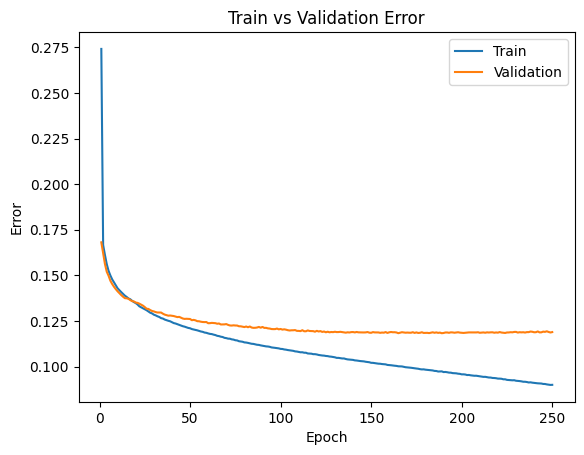

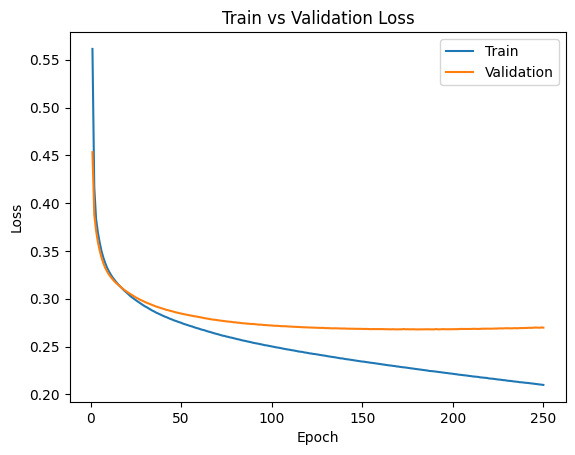

In [9]:
vgg_train(vgg_classifier().cuda(), train_data_2, val_data_2, 250, 0.0005, 256)